# **Load Data**

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings for cleaner output
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Specify the path to the dataset
file_path = '/content/drive/My Drive/data.csv'

# Load the CSV file
df = pd.read_csv(file_path, encoding='ISO-8859-1')  # Alternative encoding


# Display the dataset as a table
print("First 10 rows of the dataset:")
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Prevent line wrapping
print(df.head(10))  # Display the first 10 rows

# Display dataset info
print("\nDataset Info:")
print(df.info())

print(f'Number of rows : {df.shape[0]}')
print(f'Number of columns : {df.shape[1]}')


Mounted at /content/drive
First 10 rows of the dataset:
  InvoiceNo StockCode                          Description  Quantity     InvoiceDate  UnitPrice  CustomerID         Country
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6  12/1/2010 8:26       2.55     17850.0  United Kingdom
1    536365     71053                  WHITE METAL LANTERN         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8  12/1/2010 8:26       2.75     17850.0  United Kingdom
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6  12/1/2010 8:26       3.39     17850.0  United Kingdom
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2  12/1/2010 8:26       7.65     17850.0  United Kingdom
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6  12/1/2

# **Check missing values**

In [2]:
# Calculate missing values and their percentage
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# Create a DataFrame to display missing values and percentages
missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage Missing (%)': missing_percentage
}).sort_values(by='Missing Values', ascending=False)

# Reset index for better visualization
missing_data.reset_index(inplace=True)
missing_data.rename(columns={'index': 'Column Name'}, inplace=True)

# Display missing data summary
print("Missing Values and Their Percentages:")
print(missing_data)

# Step 2: Handle missing values
df2 = df.copy()  # Create a new DataFrame for EDA




Missing Values and Their Percentages:
   Column Name  Missing Values  Percentage Missing (%)
0   CustomerID          135080               24.926694
1  Description            1454                0.268311
2    InvoiceNo               0                0.000000
3    StockCode               0                0.000000
4     Quantity               0                0.000000
5  InvoiceDate               0                0.000000
6    UnitPrice               0                0.000000
7      Country               0                0.000000


# **Handling Missing values**

In [3]:
# Drop rows where 'CustomerID' is missing
df2.dropna(subset=['CustomerID'], inplace=True)

# Convert 'CustomerID' to integer type after handling missing values
df2['CustomerID'] = df2['CustomerID'].astype(int)

# Fill missing 'Description' with 'no description'
df2['Description'].fillna('no description', inplace=True)

#  Data transformation (convert text to lowercase, format date)
df2['Description'] = df2['Description'].str.lower()  # Convert 'Description' to lowercase
df2['InvoiceDate'] = pd.to_datetime(df2['InvoiceDate'], format='%m/%d/%Y %H:%M')  # Convert 'InvoiceDate'

# Calculate the amount spent (Quantity * UnitPrice)
df2['amount_spent'] = df2['Quantity'] * df2['UnitPrice']

# Extract year and month into a new 'year_month' column
df2.insert(loc=2, column='year_month', value=df2['InvoiceDate'].dt.year * 100 + df2['InvoiceDate'].dt.month)

# Extract month into a new 'month' column
df2.insert(loc=3, column='month', value=df2['InvoiceDate'].dt.month)

#  Extract day of the week (Monday=1 to Sunday=7)
df2.insert(loc=4, column='day', value=df2['InvoiceDate'].dt.dayofweek + 1)

#  Extract hour into a new 'hour' column
df2.insert(loc=5, column='hour', value=df2['InvoiceDate'].dt.hour)

#  Verify that missing values are handled in the cleaned DataFrame
missing_values_cleaned = df2.isnull().sum().sort_values(ascending=False)
print("Missing values after handling:\n",missing_values_cleaned)
#  Save the cleaned data to a CSV file
df2.to_csv('clean_data.csv', index=False)  # Save cleaned data to CSV

print("Data cleaning and transformation complete. Cleaned data saved to 'clean_data.csv'.")

Missing values after handling:
 InvoiceNo       0
StockCode       0
year_month      0
month           0
day             0
hour            0
Description     0
Quantity        0
InvoiceDate     0
UnitPrice       0
CustomerID      0
Country         0
amount_spent    0
dtype: int64
Data cleaning and transformation complete. Cleaned data saved to 'clean_data.csv'.


### **Exploratory Data Analysis (EDA)**
In this section, I perform an in-depth analysis of the dataset to uncover valuable insights, patterns, and trends, focusing on customer behavior, order frequency, and spending habits. Below, I break down the analysis into structured and clearly defined subsections.



## **Orders Analysis**

# Number of Orders per Customer
We begin by analyzing how many orders each customer has placed to identify customer behavior and activity patterns.

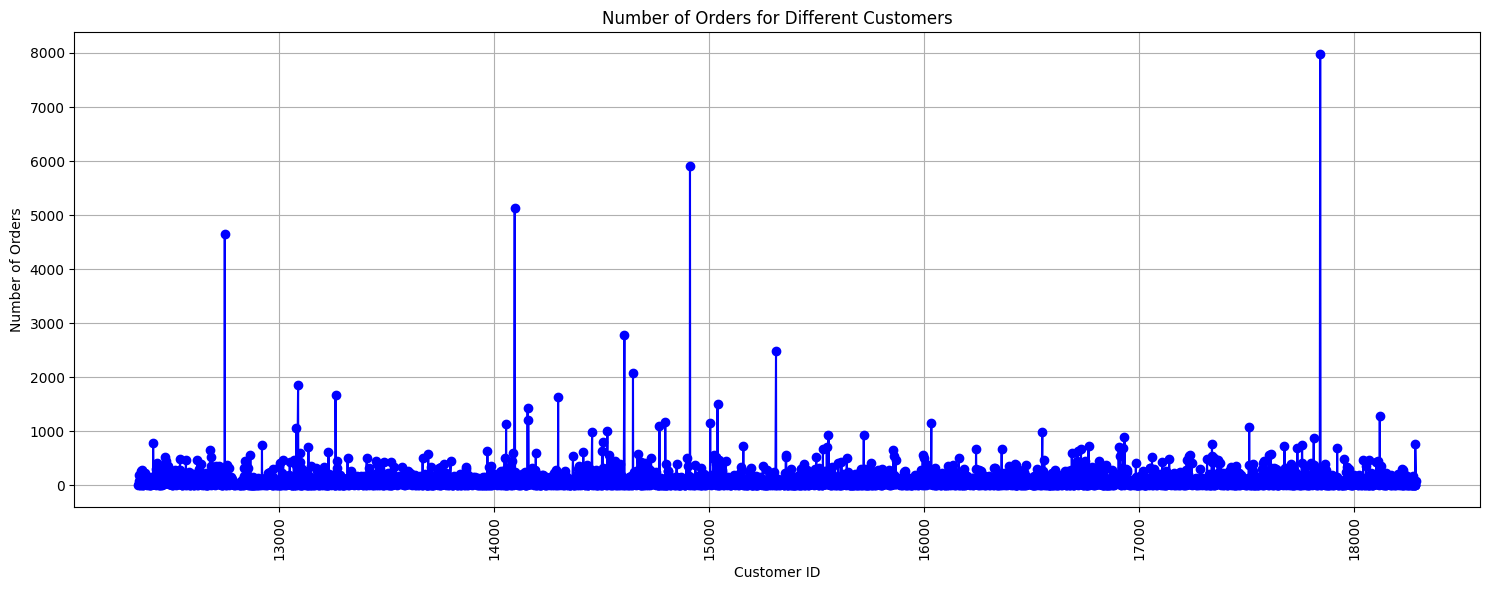

In [4]:
# Count the number of orders per CustomerID and Country
orders = df2.groupby(['CustomerID', 'Country'], as_index=False)['InvoiceNo'].count()

# Plot the total number of orders for each customer
plt.figure(figsize=(15, 6))
plt.plot(orders['CustomerID'], orders['InvoiceNo'], marker='o', linestyle='-', color='b')
plt.xlabel('Customer ID')  # X-axis label representing customer identifiers
plt.ylabel('Number of Orders')  # Y-axis label representing the count of orders
plt.title('Number of Orders for Different Customers')  # Title of the plot
plt.xticks(rotation=90)  # Rotate x-axis labels for improved visibility
plt.grid(True)  # Enable grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap of elements
plt.show()  # Render the plot



# **Top 10 Customers by Order Volume**
This section identifies and visualizes the top 10 customers with the most orders, including their respective countries to provide insights into regional customer activity

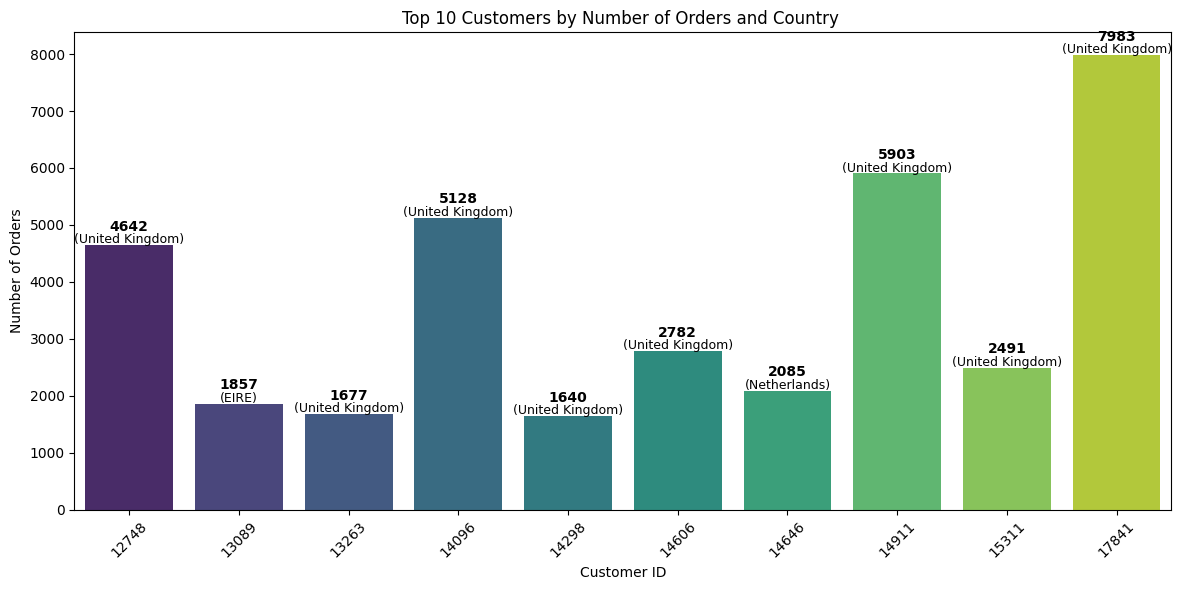

In [5]:
# Identify top customers based on order volume
# Count the number of orders per CustomerID
top_customers = df2.groupby('CustomerID', as_index=False)['InvoiceNo'].count()
# Merge 'Country' field while keeping unique CustomerID-Country pairs
top_customers = top_customers.merge(df2[['CustomerID', 'Country']].drop_duplicates(), on='CustomerID', how='left')
# Sort customers in descending order based on the number of orders
top_customers_sorted = top_customers.sort_values(by='InvoiceNo', ascending=False)

# Extract the top 10 customers with the highest order counts
top_10_customers = top_customers_sorted.head(10)

# Visualize the top 10 customers using a bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top_10_customers, x='CustomerID', y='InvoiceNo', palette='viridis')
# Annotate each bar with the order count and country
for idx, p in enumerate(ax.patches):
    customer_id = top_10_customers.iloc[idx]['CustomerID']
    country = top_10_customers.iloc[idx]['Country']

    # Display order count above the bar
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 200),
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Display country beside the bar
    ax.annotate(f'({country})',
                (p.get_x() + p.get_width() / 2., p.get_height() - 20),
                ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('Customer ID')  # X-axis label for customer identifiers
plt.ylabel('Number of Orders')  # Y-axis label for order counts
plt.title('Top 10 Customers by Number of Orders and Country ')  # Title of the bar plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility



plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()  # Render the bar plot



## **Orders for Each Country**
This section examines the total number of orders placed in each country to identify regional demand and customer distribution.

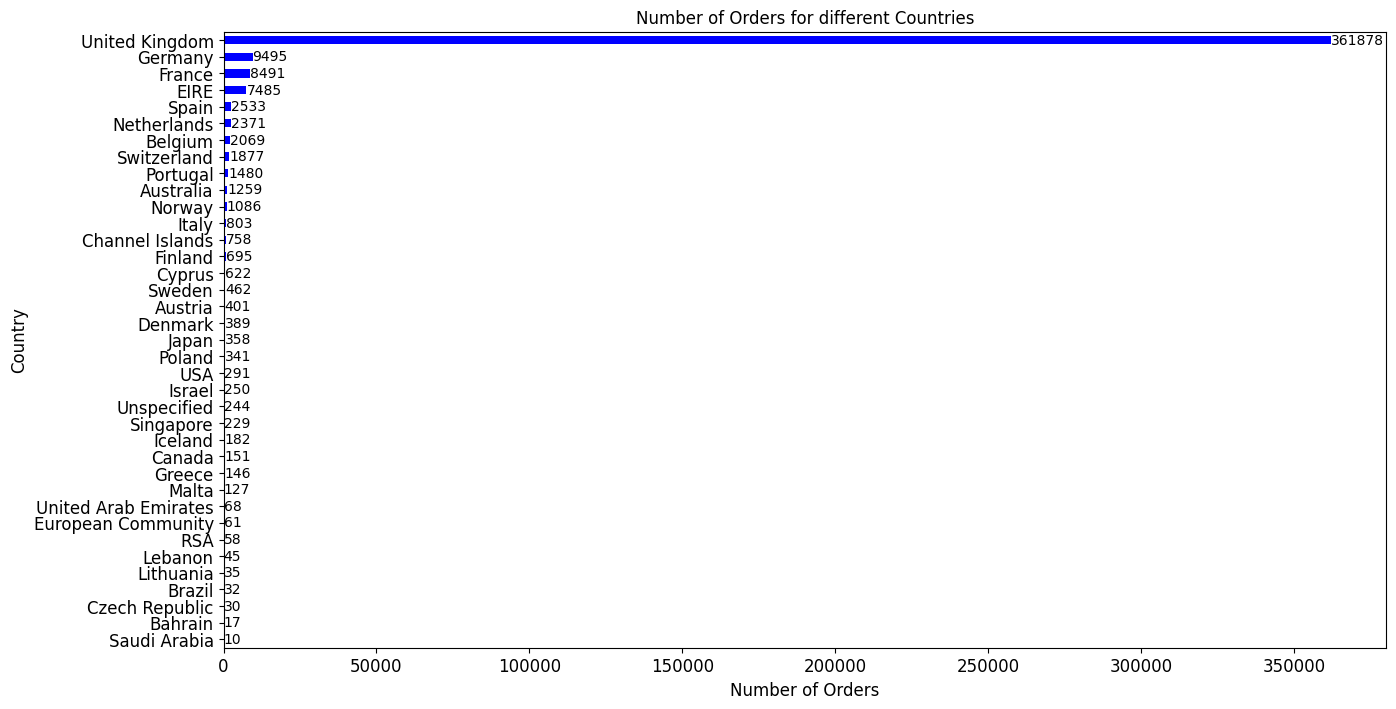

In [6]:
# Grouping by 'country' and counting the number of orders for each country
group_country_orders = df2.groupby('Country')['InvoiceNo'].count().sort_values()

# Uncomment the next line to exclude the 'United Kingdom' from the results
# del group_country_orders['United Kingdom']

# Plotting the number of orders in each country
plt.subplots(figsize=(15, 8))
ax = group_country_orders.plot(kind='barh', fontsize=12, color='blue')
plt.xlabel('Number of Orders', fontsize=12)  # Set x-axis label
plt.ylabel('Country', fontsize=12)  # Set y-axis label
plt.title('Number of Orders for different Countries', fontsize=12)  # Set plot title

# Adding the value above each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', (p.get_width(), p.get_y() + p.get_height() / 2.), ha='left', va='center', fontsize=10)

plt.show()

## **Orders per Month**
This section calculates the number of orders for each month in the dataset and visualizes them using a bar chart.

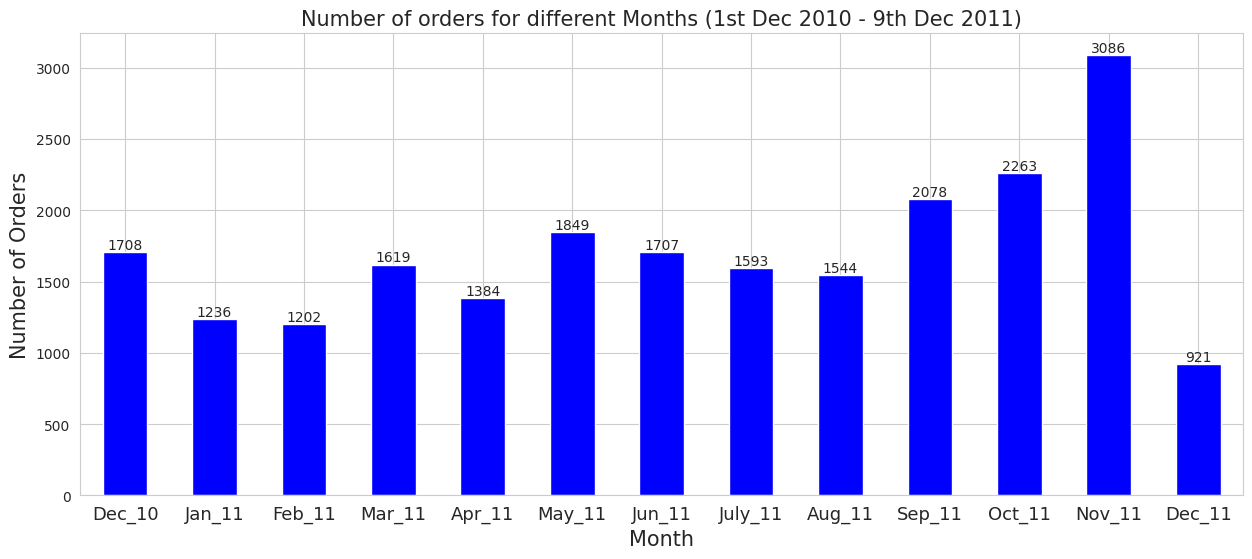

In [84]:
# Grouping by 'InvoiceNo' for the unique months and counting occurrences
ax = df2.groupby('InvoiceNo')['year_month'].unique().value_counts().sort_index().plot(kind='bar', color='blue', figsize=(15, 6))
ax.set_xlabel('Month', fontsize=15)  # Set x-axis label
ax.set_ylabel('Number of Orders', fontsize=15)  # Set y-axis label
ax.set_title('Number of orders for different Months (1st Dec 2010 - 9th Dec 2011)', fontsize=15)  # Set plot title
ax.set_xticklabels(('Dec_10', 'Jan_11', 'Feb_11', 'Mar_11', 'Apr_11', 'May_11', 'Jun_11', 'July_11', 'Aug_11', 'Sep_11', 'Oct_11', 'Nov_11', 'Dec_11'), rotation='horizontal', fontsize=13)  # Set x-tick labels

# Add value above each bar for months
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()


# **Orders per day**
This section calculates the number of orders for each day in the dataset and visualizes them using a bar chart.

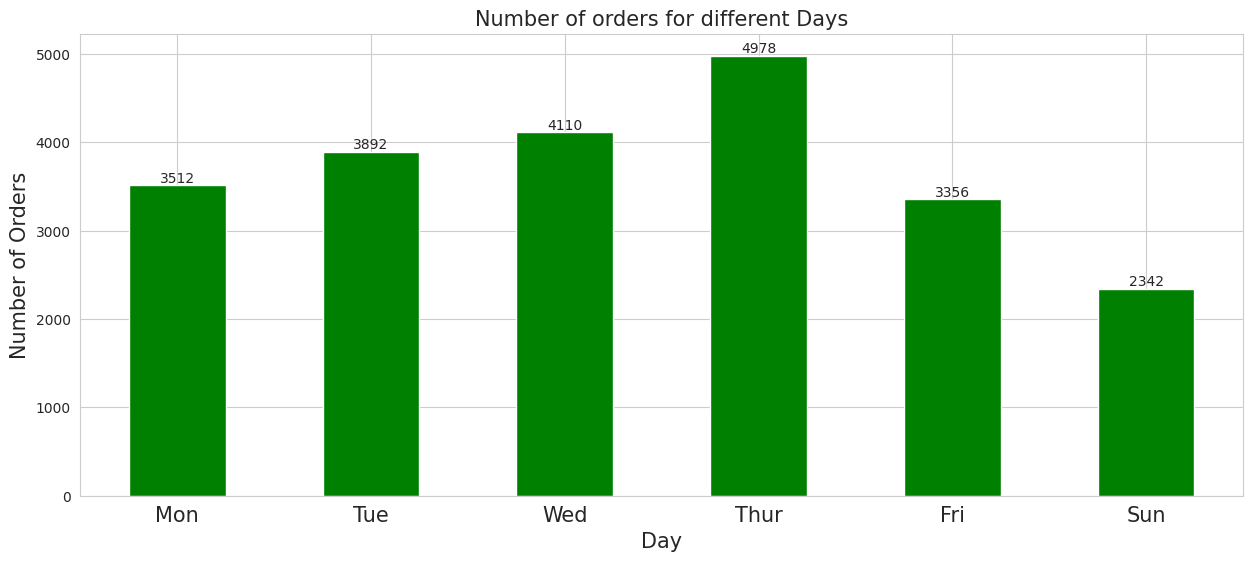

In [85]:
# Grouping by 'InvoiceNo' for the unique days and counting occurrences
ax = df2.groupby('InvoiceNo')['day'].unique().value_counts().sort_index().plot(kind='bar', color='green', figsize=(15, 6))
ax.set_xlabel('Day', fontsize=15)  # Set x-axis label
ax.set_ylabel('Number of Orders', fontsize=15)  # Set y-axis label
ax.set_title('Number of orders for different Days', fontsize=15)  # Set plot title
ax.set_xticklabels(('Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sun'), rotation='horizontal', fontsize=15)  # Set x-tick labels

# Add value above each bar for days
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()


# **Orders per hour**
This section calculates the number of orders for each hour in the dataset and visualizes them using a bar chart.

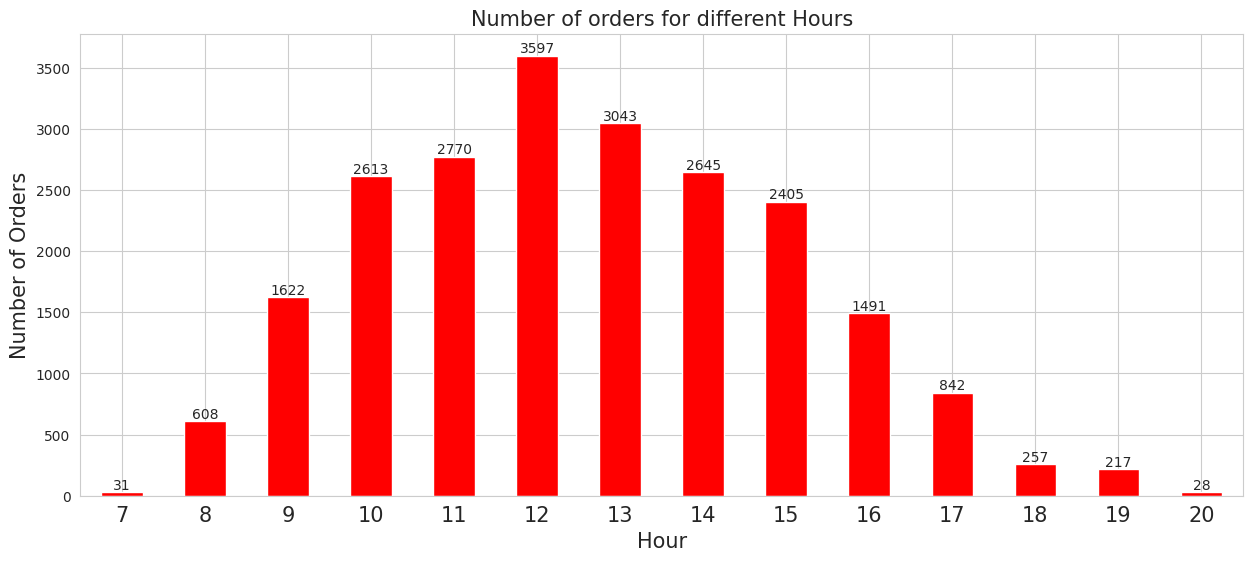

In [86]:
# Grouping by 'InvoiceNo', getting unique hours, flattening the array, and then counting occurrences
hour_counts = df2.groupby('InvoiceNo')['hour'].apply(lambda x: x.unique().tolist()).explode().value_counts().iloc[:-1].sort_index()

# Plotting the number of orders by hour
ax = hour_counts.plot(kind='bar', color='red', figsize=(15, 6))
ax.set_xlabel('Hour', fontsize=15)  # Set x-axis label
ax.set_ylabel('Number of Orders', fontsize=15)  # Set y-axis label
ax.set_title('Number of orders for different Hours', fontsize=15)  # Set plot title

# Set tick labels based on the actual hours present in the data
ax.set_xticks(range(len(hour_counts.index)))  # Use the actual length of hour_counts
ax.set_xticklabels(hour_counts.index, rotation='horizontal', fontsize=15)  # Use actual hour labels

# Add value above each bar for hours
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom', fontsize=10)

plt.show()


## **Money Spent**





# **Total Money Spent per Customer**
We begin by analyzing how much money each customer has spent to identify spending patterns and high-value customers.

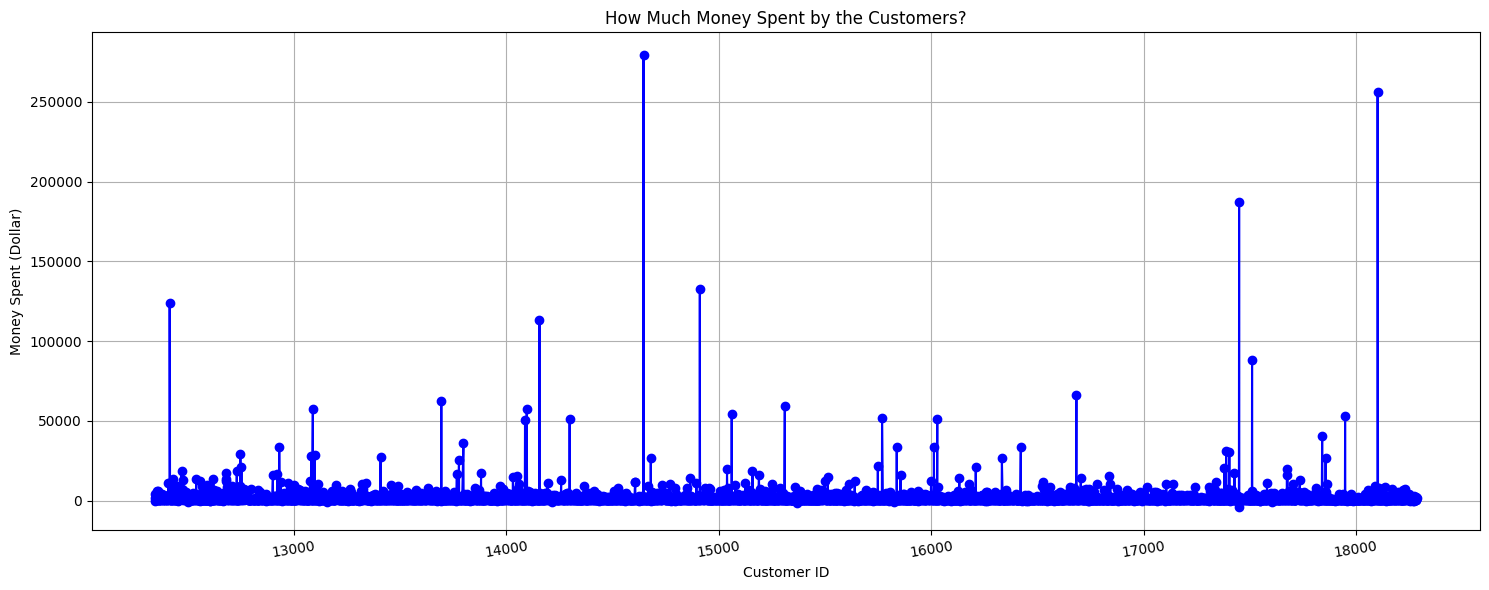

In [7]:
# Grouping by 'CustomerID' and 'Country', then summing 'amount_spent'
money_spent = df2.groupby(['CustomerID', 'Country'], as_index=False)['amount_spent'].sum()

# Visualize total money spent per customer using a line plot
plt.figure(figsize=(15, 6))  # Set the figure size for the plot
plt.plot(money_spent['CustomerID'], money_spent['amount_spent'], color='b', marker='o')  # Plotting money spent
plt.xlabel('Customer ID')  # Label for x-axis representing customer identifiers
plt.ylabel('Money Spent (Dollar)')  # Label for y-axis representing total amount spent
plt.title('How Much Money Spent by the Customers?')  # Title of the line plot
plt.xticks(rotation=9)  # Rotate x-axis labels for better readability
plt.grid(True)  # Enable grid for better readability
plt.tight_layout()  # Adjust layout to prevent overlap of elements
plt.show()  # Render the line plot




# **Top 10 Customers with the Highest Spending**
Here, we identify and visualize the top 10 customers who spent the most money, highlighting high-value customers.

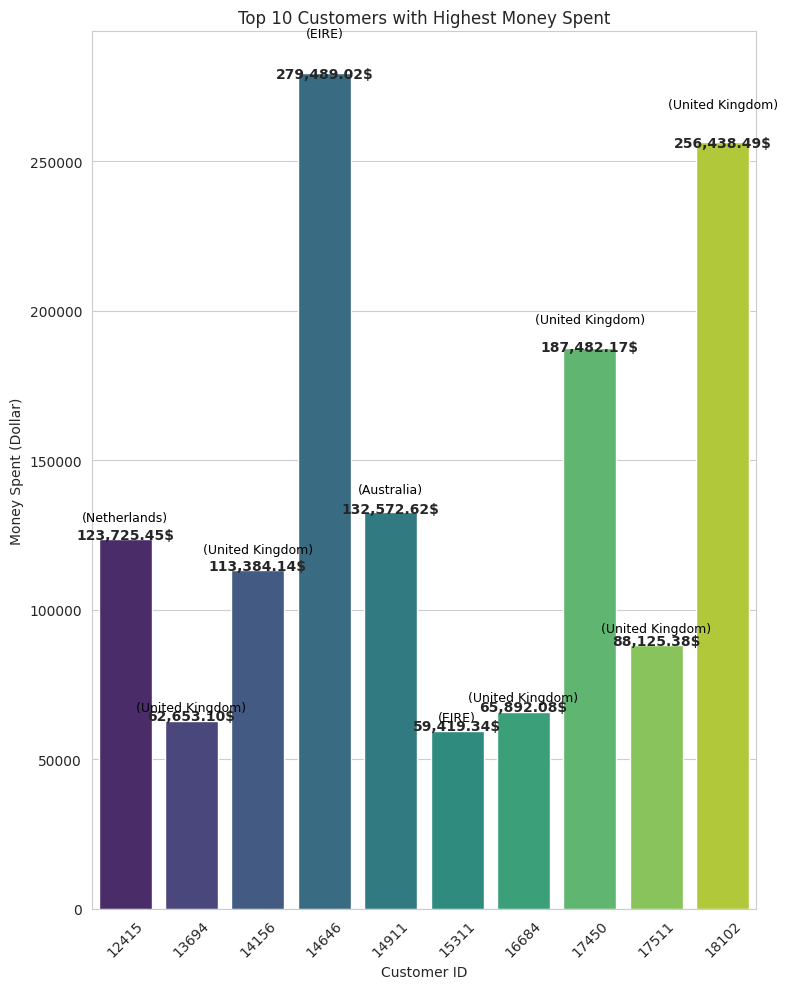

In [82]:


# Aggregate total money spent per customer and country
money_spent = df2.groupby(['CustomerID', 'Country'], as_index=False)['amount_spent'].sum()

# Sort customers by amount spent (highest first)
top_customers_sorted = money_spent.sort_values(by='amount_spent', ascending=False)
top_10_customers = top_customers_sorted.head(10)

# Create the bar plot
plt.figure(figsize=(8,10))
ax = sns.barplot(data=top_10_customers, x='CustomerID', y='amount_spent', palette='viridis')

for idx, p in enumerate(ax.patches):
    customer_id = top_10_customers.iloc[idx]['CustomerID']
    country = top_10_customers.iloc[idx]['Country']


    # Adjust position to avoid truncation
    ax.annotate(f'{float(p.get_height()):,.2f}$'  ,
                (p.get_x() + p.get_width() / 2., p.get_height()/1.01)
,  # Higher position
                ha='center', va='bottom', fontsize=10, fontweight='bold')
 # Display country beside the bar
    ax.annotate(f'({country})',
                (p.get_x() + p.get_width() / 2., p.get_height()*1.04 ),
                ha='center', va='bottom', fontsize=9, color='black')


# Labels and title
plt.xlabel('Customer ID')
plt.ylabel('Money Spent (Dollar)')
plt.title('Top 10 Customers with Highest Money Spent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## **Money Spent in Each Country**
This section analyzes the total revenue generated from each country, helping to identify the most valuable markets.

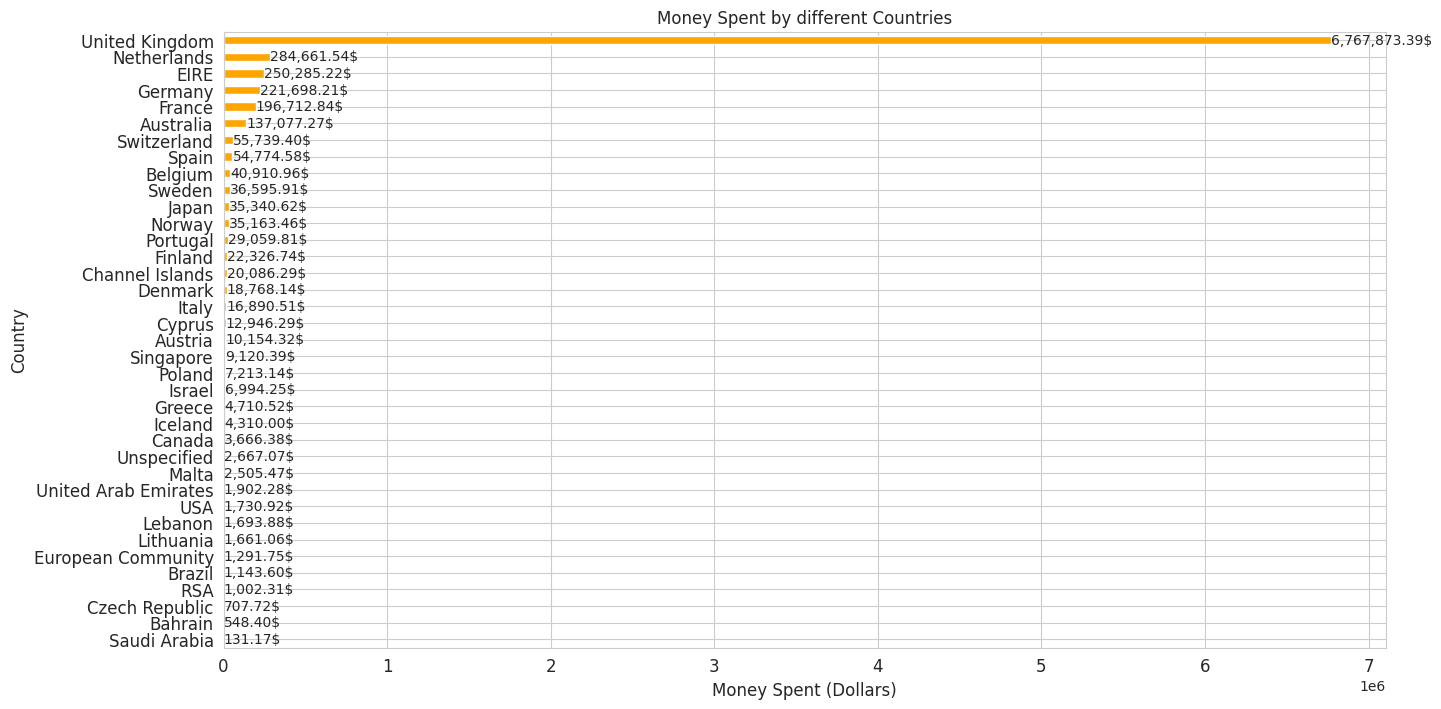

In [83]:
# Grouping by 'Country' and summing the 'amount_spent' for each country
group_country_amount_spent = df2.groupby('Country')['amount_spent'].sum().sort_values()

# Plotting the total money spent in each country
plt.subplots(figsize=(15, 8))
ax = group_country_amount_spent.plot(kind='barh', fontsize=12, color='orange')
plt.xlabel('Money Spent (Dollars)', fontsize=12)  # Set x-axis label
plt.ylabel('Country', fontsize=12)  # Set y-axis label
plt.title('Money Spent by different Countries', fontsize=12)  # Set plot title

# Adding the total amount spent above each bar
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.2f}$', (p.get_width(), p.get_y() + p.get_height() / 2.),
                 ha='left', va='center', fontsize=10)

plt.show()


## **Discover patterns for Unit Price**

Summary statistics for UnitPrice:
count    406829.000000
mean          3.460471
std          69.315162
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max       38970.000000
Name: UnitPrice, dtype: float64


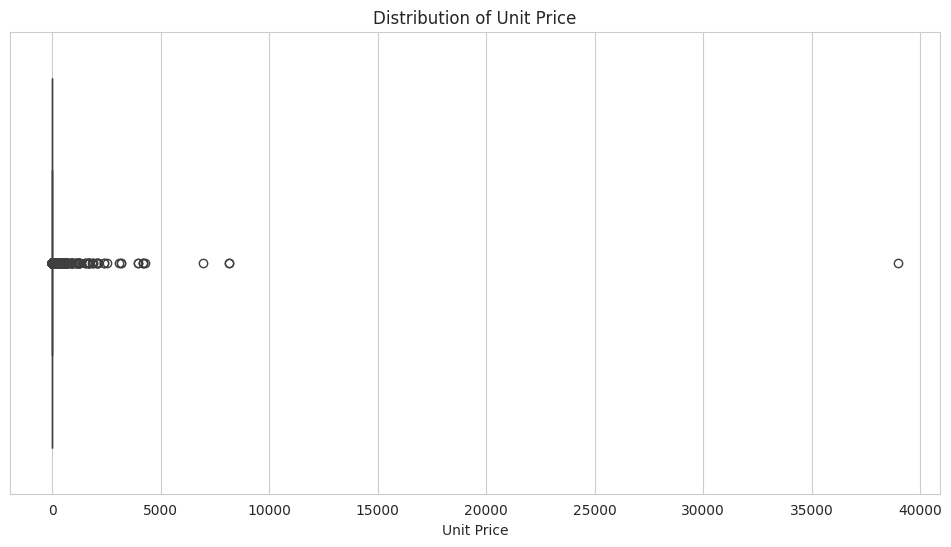

In [87]:
# Display summary statistics for the 'UnitPrice' column
unit_price_summary = df2['UnitPrice'].describe()
print("Summary statistics for UnitPrice:")
print(unit_price_summary)

# check the distribution of unit price
plt.subplots(figsize=(12, 6))  # Set the figure size
sns.boxplot(x=df2['UnitPrice'])  # Change orientation to horizontal by using 'x' for UnitPrice
plt.xlabel('Unit Price')  # Label for the x-axis
plt.title('Distribution of Unit Price')  # Title of the plot
plt.show()  # Render the plot

**We see that there are unit price = 0.000 ( FREE items)**

There are some free items given to customers from time to time.

In [95]:
df_free = df2[df2.UnitPrice == 0.000]
df_free.head()


,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
9302,537197,22841,201012,12,7,14,round cake tin vintage green,1,2010-12-05 14:02:00,0.0,12647,Germany,0.0
33576,539263,22580,201012,12,4,14,advent calendar gingham sack,4,2010-12-16 14:36:00,0.0,16560,United Kingdom,0.0
40089,539722,22423,201012,12,2,13,regency cakestand 3 tier,10,2010-12-21 13:45:00,0.0,14911,EIRE,0.0
47068,540372,22090,201101,1,4,16,paper bunting retrospot,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0.0
47070,540372,22553,201101,1,4,16,plasters in tin skulls,24,2011-01-06 16:41:00,0.0,13081,United Kingdom,0.0


In [96]:
# Count occurrences and sort by index
month_counts =df_free.year_month.value_counts().sort_index()
month_counts

,count
year_month,
201012,3
201101,3
201102,1
201103,2
201104,2
201105,2
201107,2
201108,6
201109,2


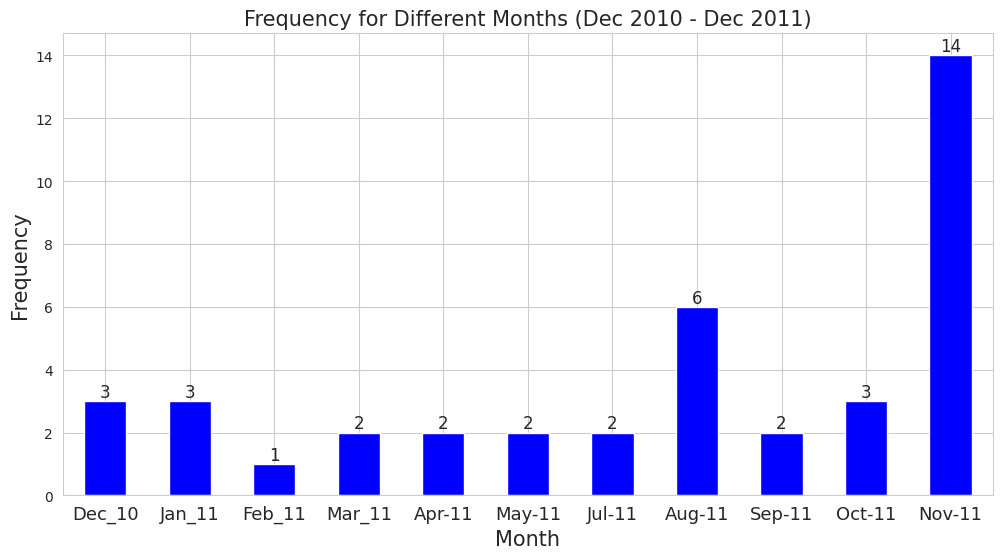

In [97]:
# Create a mapping from year_month format to month-year format
month_labels = {
    201012: 'Dec_10',
    201101: 'Jan_11',
    201102: 'Feb_11',
    201103: 'Mar_11',
    201104: 'Apr-11',
    201105: 'May-11',
    201106: 'Jun-11',
    201107: 'Jul-11',
    201108: 'Aug-11',
    201109: 'Sep-11',
    201110: 'Oct-11',
    201111: 'Nov-11',
    201112: 'Dec-11',
}

# Use the mapping to set the x-tick labels
ax = month_counts.plot(kind='bar', figsize=(12, 6), color='blue')

# Set axis labels and title
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('Frequency for Different Months (Dec 2010 - Dec 2011)', fontsize=15)

# Set x-tick labels from the mapping, ensuring only relevant labels are displayed
ax.set_xticks(range(len(month_counts)))
ax.set_xticklabels([month_labels[month] for month in month_counts.index], rotation='horizontal', fontsize=13)

# Adding values on top of bars
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() ,  # Add a little space above the bar
            int(bar.get_height()),  # Display the height as an integer
            ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()


## **Less than 1$**

In [98]:
df_less = df2[df2.UnitPrice < 1.0]
df_less.head()

,InvoiceNo,StockCode,year_month,month,day,hour,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount_spent
29,536370,21724,201012,12,3,8,panda and bunnies sticker sheet,12,2010-12-01 08:45:00,0.85,12583,France,10.20
30,536370,21883,201012,12,3,8,stars gift tape,24,2010-12-01 08:45:00,0.65,12583,France,15.60
31,536370,10002,201012,12,3,8,inflatable political globe,48,2010-12-01 08:45:00,0.85,12583,France,40.80
38,536370,22661,201012,12,3,8,charlotte bag dolly girl design,20,2010-12-01 08:45:00,0.85,12583,France,17.00
42,536370,22540,201012,12,3,8,mini jigsaw circus parade,24,2010-12-01 08:45:00,0.42,12583,France,10.08


In [99]:

# Count occurrences and sort by index
month_countsless =df_less.year_month.value_counts().sort_index()
month_countsless

,count
year_month,
201012,5032
201101,4478
201102,4049
201103,6177
201104,5601
201105,6010
201106,6433
201107,7504
201108,6644


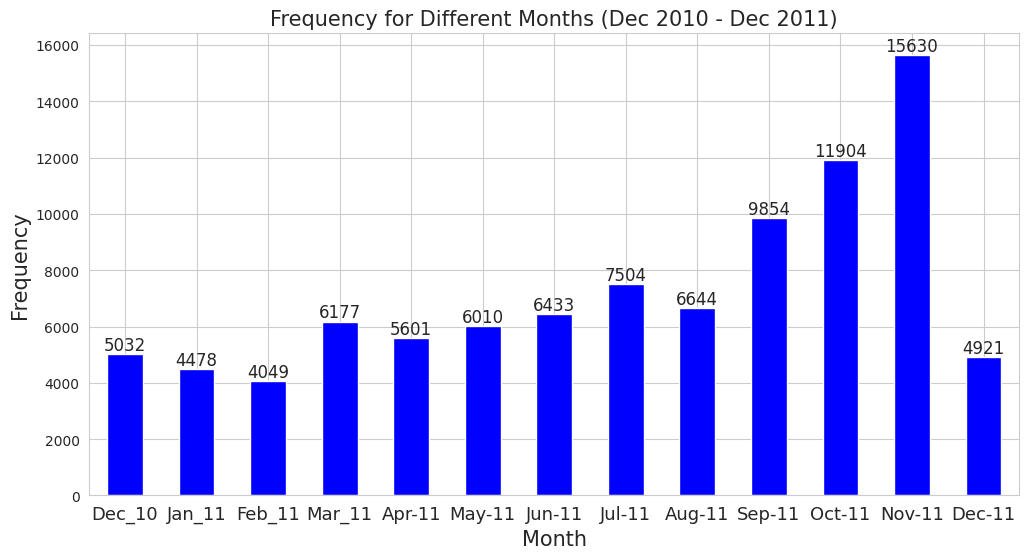

In [100]:
# Use the mapping to set the x-tick labels
ax = month_countsless.plot(kind='bar', figsize=(12, 6), color='blue')

# Set axis labels and title
ax.set_xlabel('Month', fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_title('Frequency for Different Months (Dec 2010 - Dec 2011)', fontsize=15)

# Set x-tick labels from the mapping, ensuring only relevant labels are displayed
ax.set_xticks(range(len(month_countsless)))
ax.set_xticklabels([month_labels[month] for month in month_countsless.index], rotation='horizontal', fontsize=13)

# Adding values on top of bars
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,  # Add a little space above the bar
            int(bar.get_height()),  # Display the height as an integer
            ha='center', va='bottom', fontsize=12)

# Show the plot
plt.show()

In [101]:
# Count occurrences of each unique UnitPrice
price_counts = df_less.UnitPrice.value_counts()

# Get the last 10 unique prices (sorted by price)
last_10_prices = price_counts.sort_index().head(20)

# Create a DataFrame for better display
price_table = pd.DataFrame(last_10_prices).reset_index()
price_table.columns = ['UnitPrice', 'Count']  # Rename columns for clarity

# Display the table
print(price_table)

    UnitPrice  Count
0       0.000     40
1       0.001      4
2       0.010      1
3       0.030      3
4       0.040     66
5       0.060    113
6       0.070      9
7       0.080     56
8       0.090      2
9       0.100     53
10      0.110      2
11      0.120    638
12      0.140     89
13      0.160     46
14      0.170      8
15      0.180     25
16      0.190   1893
17      0.200     16
18      0.210   1131
19      0.220     13
